# Importar librerias




In [ ]:
!pip install -qqq git+https://github.com/huggingface/diffusers.git gradio transformers accelerate safetensors
!pip install transformers timm

# boundig boxes
import random
import PIL
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import io
import torch
from transformers import DetrImageProcessor, DetrForObjectDetection

import datetime
from PIL import Image

import os

#server
from werkzeug.serving import make_server
from flask import Flask, request
import threading
import requests

#buckets
import pathlib
from google.cloud import storage


#detectron
import sys
import distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))



In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)


import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import json
import cv2
import random
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from detectron2.utils.visualizer import Visualizer

# Iniciar Server

In [ ]:
default_port = 6060

class ServerThread(threading.Thread):

    def __init__(self, app, port):
        threading.Thread.__init__(self)
        self.port = port
        self.srv = make_server('127.0.0.1', port, app)
        self.ctx = app.app_context()
        self.ctx.push()
    def run(self):
        print('starting server on port:',self.port)
        self.srv.serve_forever()

    def shutdown(self):
        self.srv.shutdown()

def start_server(port=default_port):
    global server
    if 'server' in globals() and server:
      print('stopping server')
      stop_server()

    app = Flask('myapp')
    # you can add your own routes here as needed
    @app.route("/")
    def hello():
      # A wee bit o'html
      return '<h1 style="color:red;">Hello From Flask!</h1>'
    server = ServerThread(app,port)
    server.start()
    @app.route('/uploadFile',  methods=['GET', 'POST'])
    def uploadFile():
      request_data = request.json
      print(request_data)

      model = request_data['model']

      buckets = request_data['buckets']
      clases =request_data['clases']
      directory = request_data['directory']
      data={'model':model,
            'buckets':buckets,
            'clases': clases,
            'directory':directory,

            }
      return data

def stop_server():
    global server
    if server:
      server.shutdown()
      server = None
# Start the server here
start_server()

# Requests

In [ ]:

data = {
    "model" : ['detectron2', 'YOLO'],
    "buckets" : ['imges_storage'],
    "clases" : ['dog'],
    "directory":['imagenes/val/' ]

}
r = requests.post('http://localhost:6060/uploadFile',json=data)
r = r.json()
bucket_name = r['buckets'][0]
directory_in_bucket = r['directory'][0]


# Descargar carpetas de google

In [ ]:
def download_data_from_bucket(bucket_name, directory_in_bucket):
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'servicekey_google_cloud.json'
    storage_client = storage.Client()


    blobs_in_bucket = storage_client.list_blobs(
      bucket_name, prefix=directory_in_bucket
    )
    try:
      for blob in blobs_in_bucket:
          local_filename = (
            pathlib.Path("/content/images/train/") / blob.name.split("/")[-1]
          ).resolve()
          blob.download_to_filename(filename=str(local_filename))
    except Exception as e:
      print(e)

In [ ]:
os.makedirs('./images/train/')

In [ ]:
download_data_from_bucket(bucket_name, directory_in_bucket)


# Extraer imagenes de carpeta

In [ ]:
base_path_val = '/content/images/train/'
#TRAIN = '/content/imagenes/imagenes/train'
#TEST = '/content/imagenes/imagenes/test'

In [ ]:
directories = [base_path_val]
train_images =[]
val_images =[]
val_data =[]
for directory in directories:
  for files in  os.listdir(directory):

    if files.endswith('.jpg'):
      if directory == base_path_val:
        val_images.append(files)
      """if directory == TRAIN:
        train_images.append(files)"""

In [ ]:
import jsonConverter

In [ ]:

annotations_coco = jsonConverter.generate_bounding_box( base_path_val,val_images)
annotations_coco

In [ ]:
import json

In [ ]:

with open("annotations_coco.json", "w") as fp:
    json.dump(annotations_coco,fp)

# Detectron2

In [ ]:


from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dog_trains", {}, "/content/annotations_coco.json", "/content/images/train")
#register_coco_instances("my_dog_val", {}, "/content/imagenes/val/via_region_data.json", "/content/imagenes/val")



In [ ]:
my_dataset_train_metadata = MetadataCatalog.get("my_dog_trains")
dataset_dicts = DatasetCatalog.get("my_dog_trains")

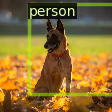

In [ ]:
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
DatasetCatalog

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)


In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dog_trains",)
#cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 400 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (100, 500)
cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4

cfg.TEST.EVAL_PERIOD = 500

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/15 20:38:38 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
model_final_68b088.pkl: 421MB [00:05, 79.4MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[06/15 20:38:43 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/15 20:40:07 d2.utils.events]:  eta: 0:23:39  iter: 19  total_loss: 2.447  loss_cls: 1.624  loss_box_reg: 0.6914  loss_rpn_cls: 0.08732  loss_rpn_loc: 0.03218    time: 3.6888  last_time: 3.9553  data_time: 0.0653  last_data_time: 0.0504   lr: 3.3275e-06  max_mem: 10913M
[06/15 20:41:27 d2.utils.events]:  eta: 0:23:20  iter: 39  total_loss: 2.366  loss_cls: 1.554  loss_box_reg: 0.6282  loss_rpn_cls: 0.09262  loss_rpn_loc: 0.02728    time: 3.8602  last_time: 4.2259  data_time: 0.0313  last_data_time: 0.0129   lr: 5.7775e-06  max_mem: 10913M
[06/15 20:42:50 d2.utils.events]:  eta: 0:22:33  iter: 59  total_loss: 2.231  loss_cls: 1.423  loss_box_reg: 0.6382  loss_rpn_cls: 0.08799  loss_rpn_loc: 0.03025    time: 3.9484  last_time: 4.5327  data_time: 0.0302  last_data_time: 0.0232   lr: 8.2275e-06  max_mem: 10913M
[06/15 20:44:10 d2.utils.events]:  eta: 0:21:18  iter: 79  total_loss: 2.073  loss_cls: 1.252  loss_box_reg: 0.6706  loss_rpn_cls: 0.08011  loss_rpn_loc: 0.03164    time: 3.9624 

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 25>:25                                                                            │
│                                                                                                  │
│ /content/detectron2/detectron2/engine/defaults.py:484 in train                                   │
│                                                                                                  │
│   481 │   │   Returns:                                                                           │
│   482 │   │   │   OrderedDict of results, if evaluation is enabled. Otherwise None.              │
│   483 │   │   """                                                                                │
│ ❱ 484 │   │   super().train(self.start_iter, self.max_iter)                                      │
│   485 │   │   if len(self.cfg.TEST.EXPECTED_RESULTS) and comm.is_main_process():                 │
│   486 │   │   │   assert hasattr(                                                                │
│   487 │   │   │   │   self, "_last_eval_results"                                                 │
│                                                                                                  │
│ /content/detectron2/detectron2/engine/train_loop.py:165 in train                                 │
│                                                                                                  │
│   162 │   │   │   │   logger.exception("Exception during training:")                             │
│   163 │   │   │   │   raise                                                                      │
│   164 │   │   │   finally:                                                                       │
│ ❱ 165 │   │   │   │   self.after_train()                                                         │
│   166 │                                                                                          │
│   167 │   def before_train(self):                                                                │
│   168 │   │   for h in self._hooks:                                                              │
│                                                                                                  │
│ /content/detectron2/detectron2/engine/train_loop.py:174 in after_train                           │
│                                                                                                  │
│   171 │   def after_train(self):                                                                 │
│   172 │   │   self.storage.iter = self.iter                                                      │
│   173 │   │   for h in self._hooks:                                                              │
│ ❱ 174 │   │   │   h.after_train()                                                                │
│   175 │                                                                                          │
│   176 │   def before_step(self):                                                                 │
│   177 │   │   # Maintain the invariant that storage.iter == trainer.iter                         │
│                                                                                                  │
│ /content/detectron2/detectron2/engine/hooks.py:561 in after_train                                │
│                                                                                                  │
│   558 │   def after_train(self):                                                                 │
│   559 │   │   # This condition is to prevent the eval from running after a failed training       │
│   560 │   │   if self._eval_after_train and self.trainer.iter + 1 >= self.trainer.max_iter:      │
│ ❱ 561 │   │   │   self._do_eval()                                                                │
│   562 │   │   # func is likely a closure that holds referen

In [ ]:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[06/15 21:07:44 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 2>:2                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'get_balloon_dicts' is not defined

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("balloon_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "balloon_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

In [ ]:
cfg = get_cfg()   # get a fresh new config
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
import shutil
shutil.rmtree('/content/images/')
